### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import arabic_reshaper
from bidi.algorithm import get_display
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

### Reading data and Exploration

In [2]:
data_set = pd.read_csv('sales_dataset_en_headers.csv', encoding='utf-8')
print("Dataset Info:")
print(data_set.info())
print("\nFirst five rows:")
print(data_set.head())
print("\nMissing Values:")
print(data_set.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           1007 non-null   int64  
 1   order_date         1007 non-null   object 
 2   order_count        1007 non-null   int64  
 3   shiping_method     1007 non-null   object 
 4   unit_price         1007 non-null   float64
 5   customer_name      1007 non-null   object 
 6   customer_division  1007 non-null   object 
 7   product_category   1007 non-null   object 
 8   sale               999 non-null    object 
 9   profit             999 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 78.8+ KB
None

First five rows:
   order_id  order_date  order_count shiping_method  unit_price  \
0         3  10/13/2010            6     هوایی عادی       38.94   
1         6   2/20/2012            2     هوایی عادی        2.08   
2        32   7/

###  Data preprocessing

#### Prepare persian content to be shown correctly

In [3]:
def reshape_persian(text):
    return get_display(arabic_reshaper.reshape(str(text)))
data_set['shiping_method'] = data_set['shiping_method'].apply(reshape_persian)
data_set['product_category'] = data_set['product_category'].apply(reshape_persian)
data_set['customer_division'] = data_set['customer_division'].apply(reshape_persian)

#### Convert Excel serial date to datetime

In [4]:
data_set['order_date'] = pd.to_datetime(data_set['order_date'], dayfirst=True)

#### extract numbers in sale and profit column
a function that returns a float from a string

In [5]:
def extract_number_from_string(text):
    if isinstance(text, str):
        string_number = ''.join(char for char in str(text) if char.isdigit() or char == '.')
        return float(string_number)
    return None

create new columns for numerical sale and profit

In [6]:
data_set['sale'] = data_set['sale'].apply(extract_number_from_string)
data_set['profit'] = data_set['profit'].apply(extract_number_from_string)
data_set.head()

,order_id,order_date,order_count,shiping_method,unit_price,customer_name,customer_division,product_category,sale,profit
0,3,2010-10-13,6,ﯼﺩﺎﻋ ﯽﯾﺍﻮﻫ,38.94,Muhammed MacIntyre,ﮏﭼﻮﮐ ﺭﺎﮐﻭﺐﺴﮐ,ﯼﺭﺍﺩﺍ ﻡﺯﺍﻮﻟ,261.54,213.25
1,6,2012-02-20,2,ﯼﺩﺎﻋ ﯽﯾﺍﻮﻫ,2.08,Ruben Dartt,ﯽﺘﮐﺮﺷ,ﯼﺭﺍﺩﺍ ﻡﺯﺍﻮﻟ,6.93,4.64
2,32,2011-07-15,26,ﯼﺩﺎﻋ ﯽﯾﺍﻮﻫ,107.53,Liz Pelletier,ﯽﺘﮐﺮﺷ,ﻥﺎﻤﻠﺒﻣ,2808.08,1054.82
3,32,2011-07-15,24,ﻞﯾﻮﺤﺗ ﻥﻮﯿﻣﺎﮐ,70.89,Liz Pelletier,ﯽﺘﮐﺮﺷ,ﻥﺎﻤﻠﺒﻣ,1761.40,1748.56
4,32,2011-07-15,23,ﯼﺩﺎﻋ ﯽﯾﺍﻮﻫ,7.99,Liz Pelletier,ﯽﺘﮐﺮﺷ,ﯼﮊﻮﻟﻮﻨﮑﺗ,160.23,85.13


#### Handle missing values in sales and profit

In [7]:
data_set['sale/(order_count*unit_price)'] = data_set['sale'] / (data_set['order_count'] * data_set['unit_price'])
s_by_oc_up_median = data_set['sale/(order_count*unit_price)'].median()
data_set['sale'] = data_set.apply(lambda row: row['order_count'] * row['unit_price'] * s_by_oc_up_median if pd.isna(row['sale']) else row['sale'], axis=1)

data_set['profit_margin'] = data_set['profit'] / data_set['sale']
median_ratios = data_set.groupby('product_category')['profit_margin'].median()

data_set['median_profit_ratio'] = data_set['product_category'].map(median_ratios)
data_set['profit'] = data_set.apply(lambda row: row['sale'] * row['median_profit_ratio'] if pd.isna(row['profit']) else row['profit'], axis=1)
data_set['profit_margin'] = (data_set['profit'] / data_set['sale'] * 100).round(2)

#### checking the missing values a barplot

<Axes: >

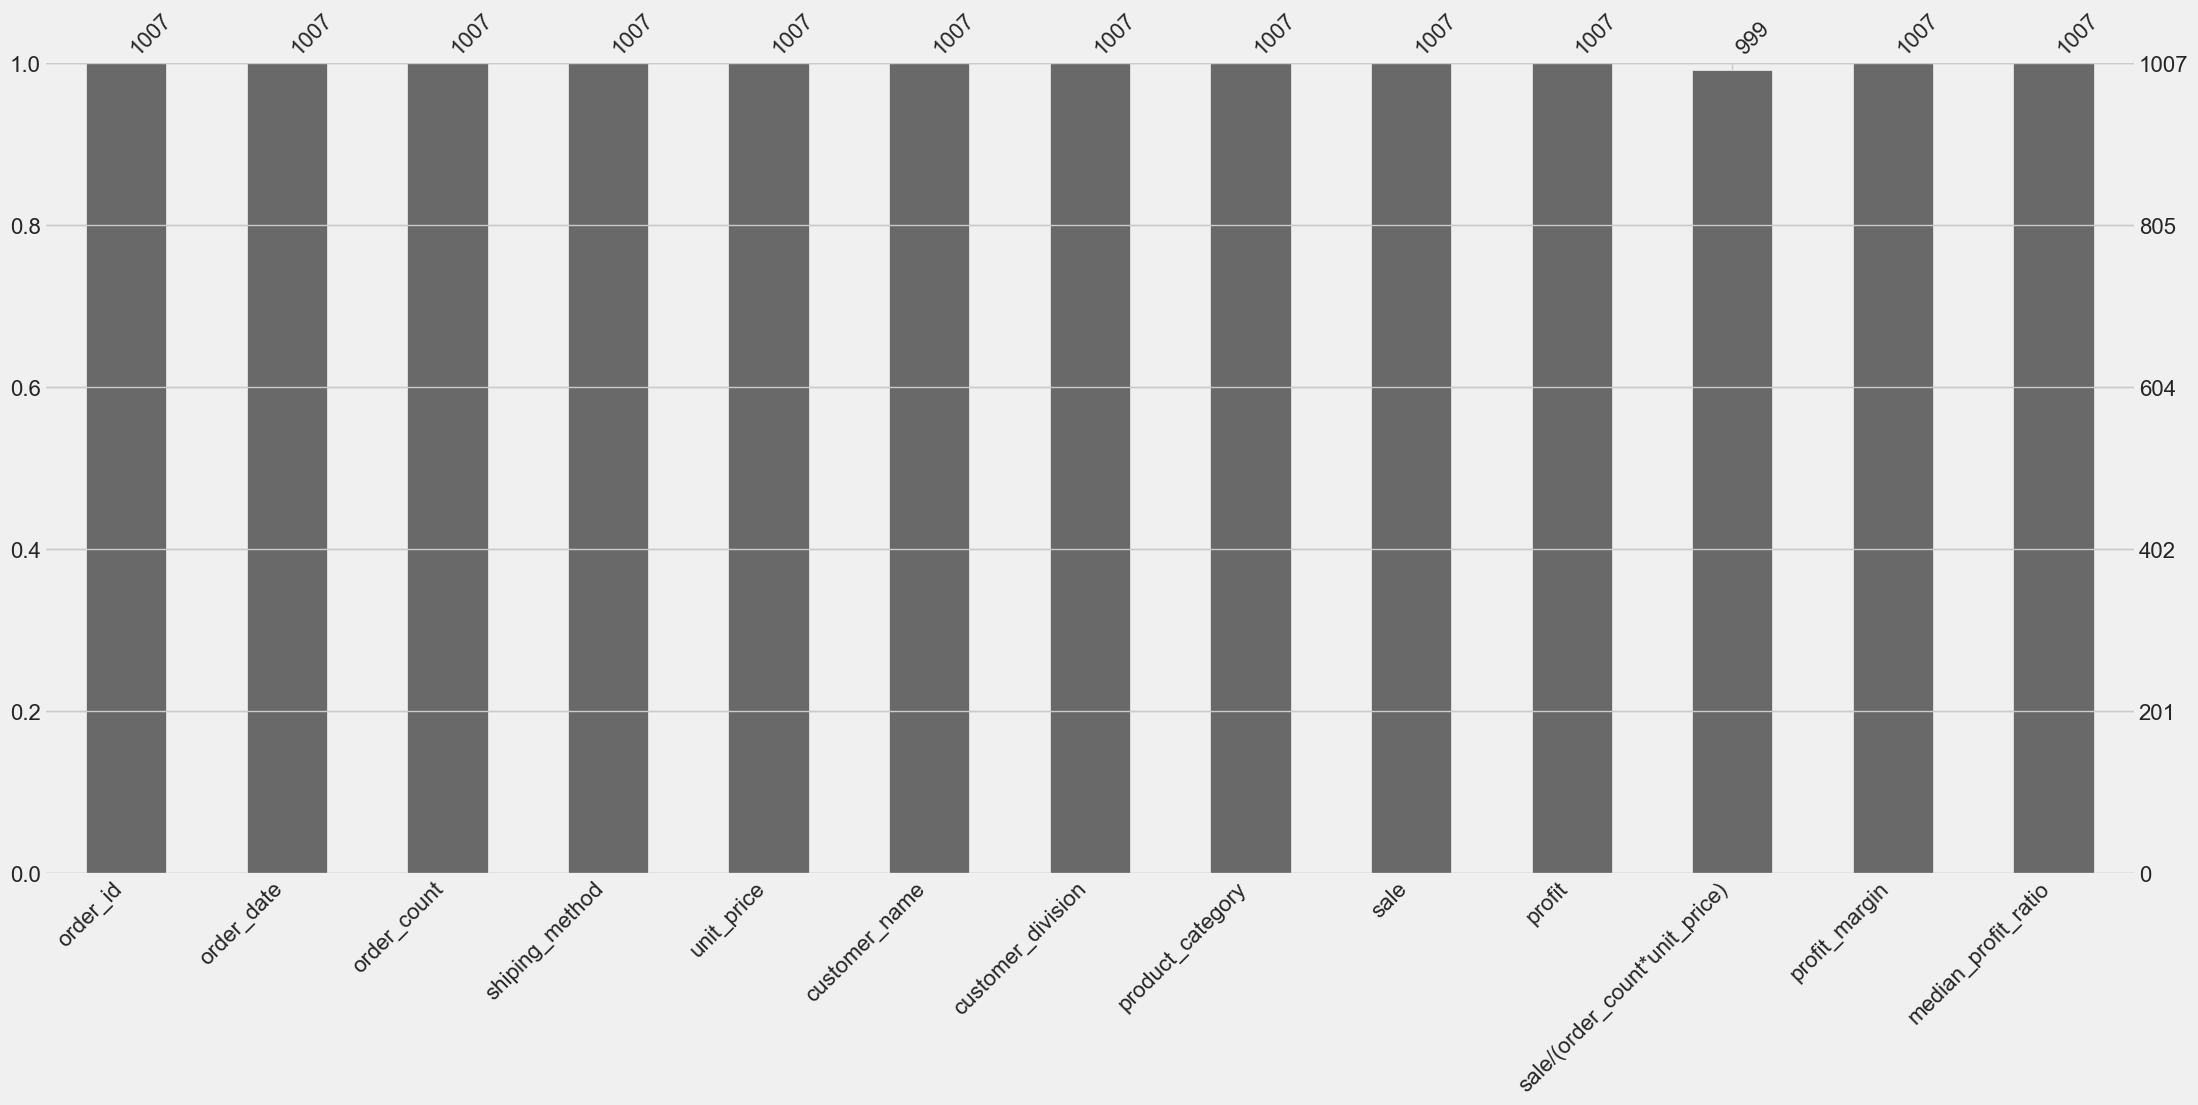

In [8]:
msno.bar(data_set)

In the code below we are going to get rid of unnecessary columns.

<Axes: >

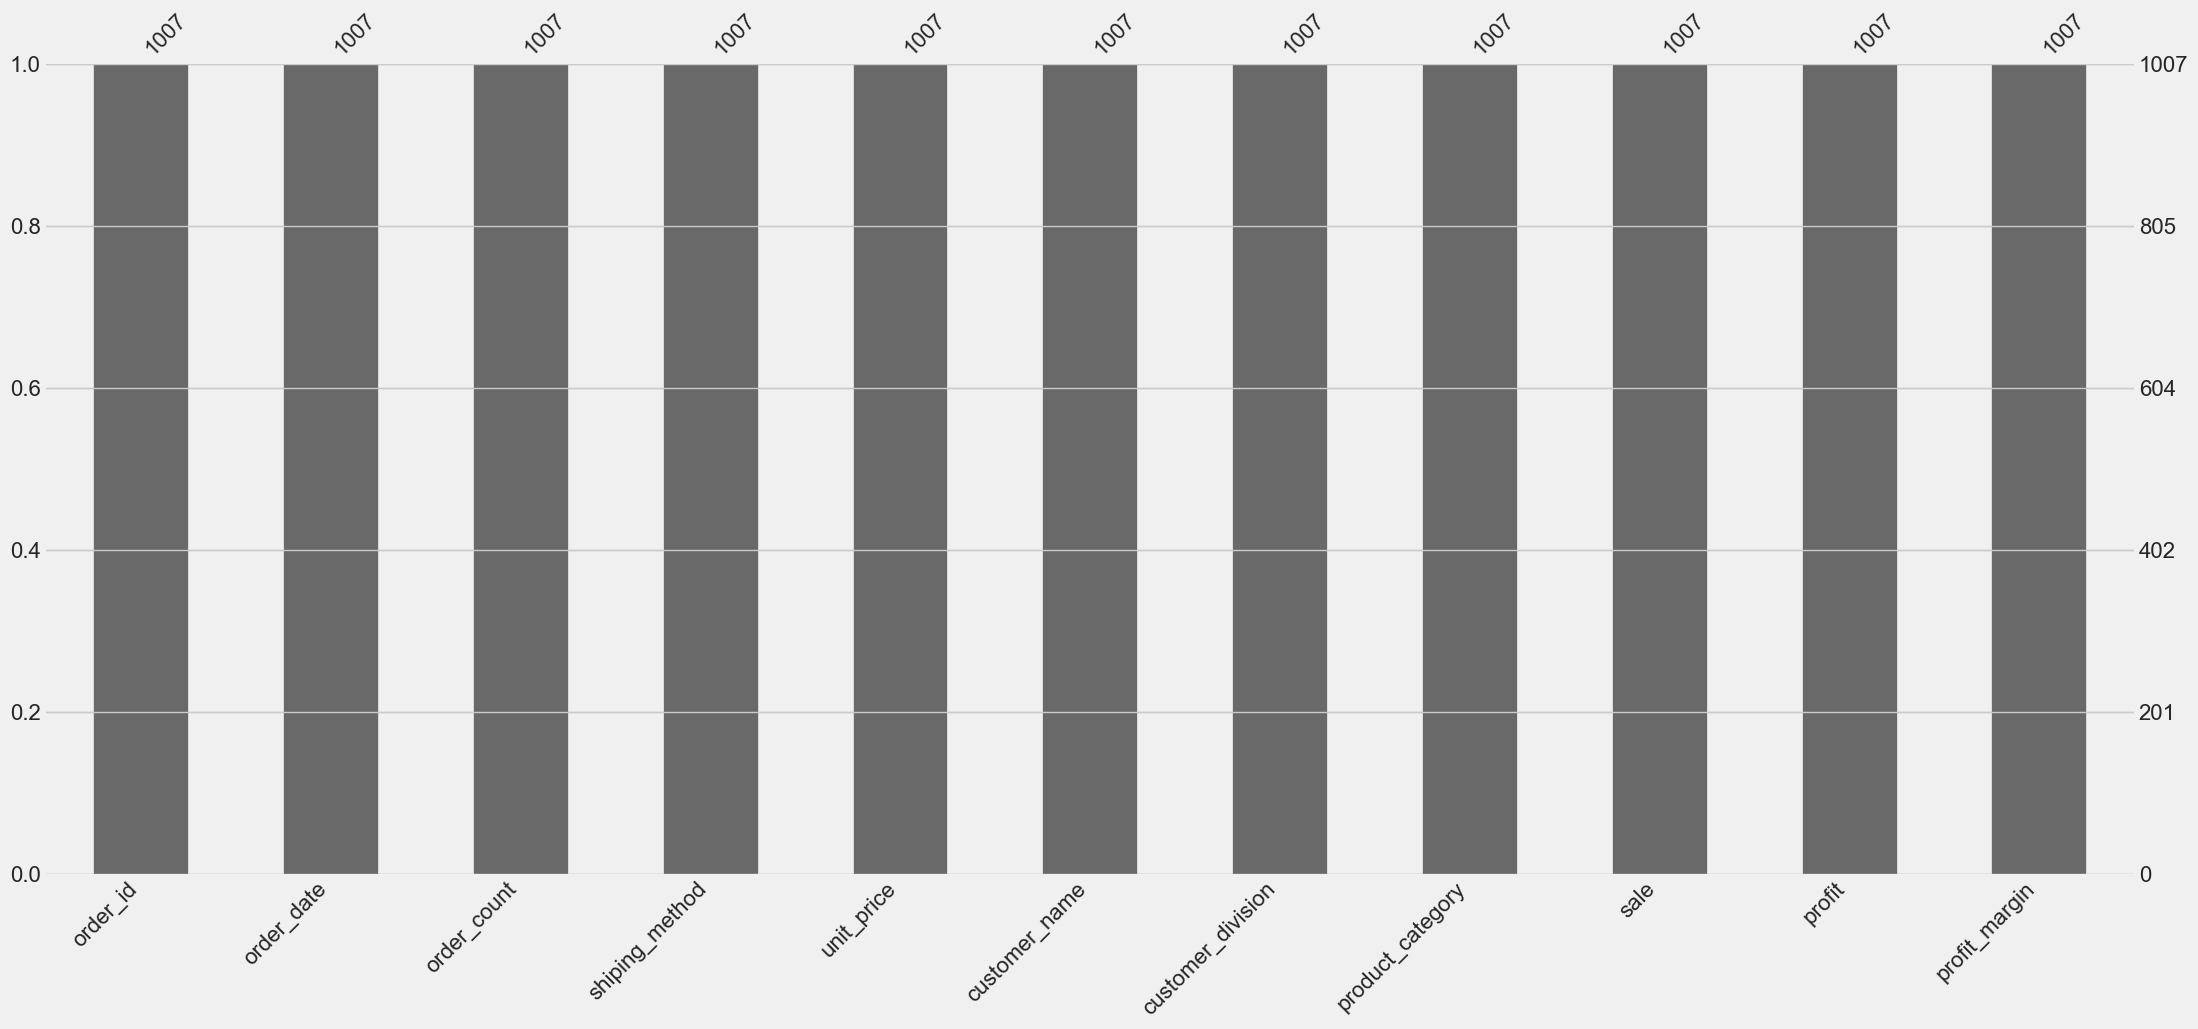

In [9]:
data_set = data_set.drop(columns=['sale/(order_count*unit_price)', 'median_profit_ratio'])
msno.bar(data_set)

### Exploratory Data Analysis

#### Statistics summary

In [10]:
data_set.describe()

,order_id,order_date,order_count,unit_price,sale,profit,profit_margin
count,1007.000000,1007,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,3478.923535,2010-12-24 04:24:32.889771776,24.832175,91.255045,1868.130972,442.666448,34.730765
min,3.000000,2008-07-15 00:00:00,1.000000,1.260000,2.240000,0.030000,0.050000
25%,1665.500000,2010-01-05 00:00:00,12.000000,6.480000,132.950000,29.695000,11.905000
50%,3456.000000,2010-12-24 00:00:00,25.000000,20.970000,416.400000,100.050000,24.420000
75%,5350.000000,2012-01-04 00:00:00,38.000000,95.950000,1715.239440,354.820000,42.145000
max,7239.000000,2012-12-28 00:00:00,50.000000,6783.020000,45923.760000,11535.280000,831.900000
std,2119.704215,NaN,14.367466,294.993321,3838.064873,1064.048487,50.966466


#### Distribution plots

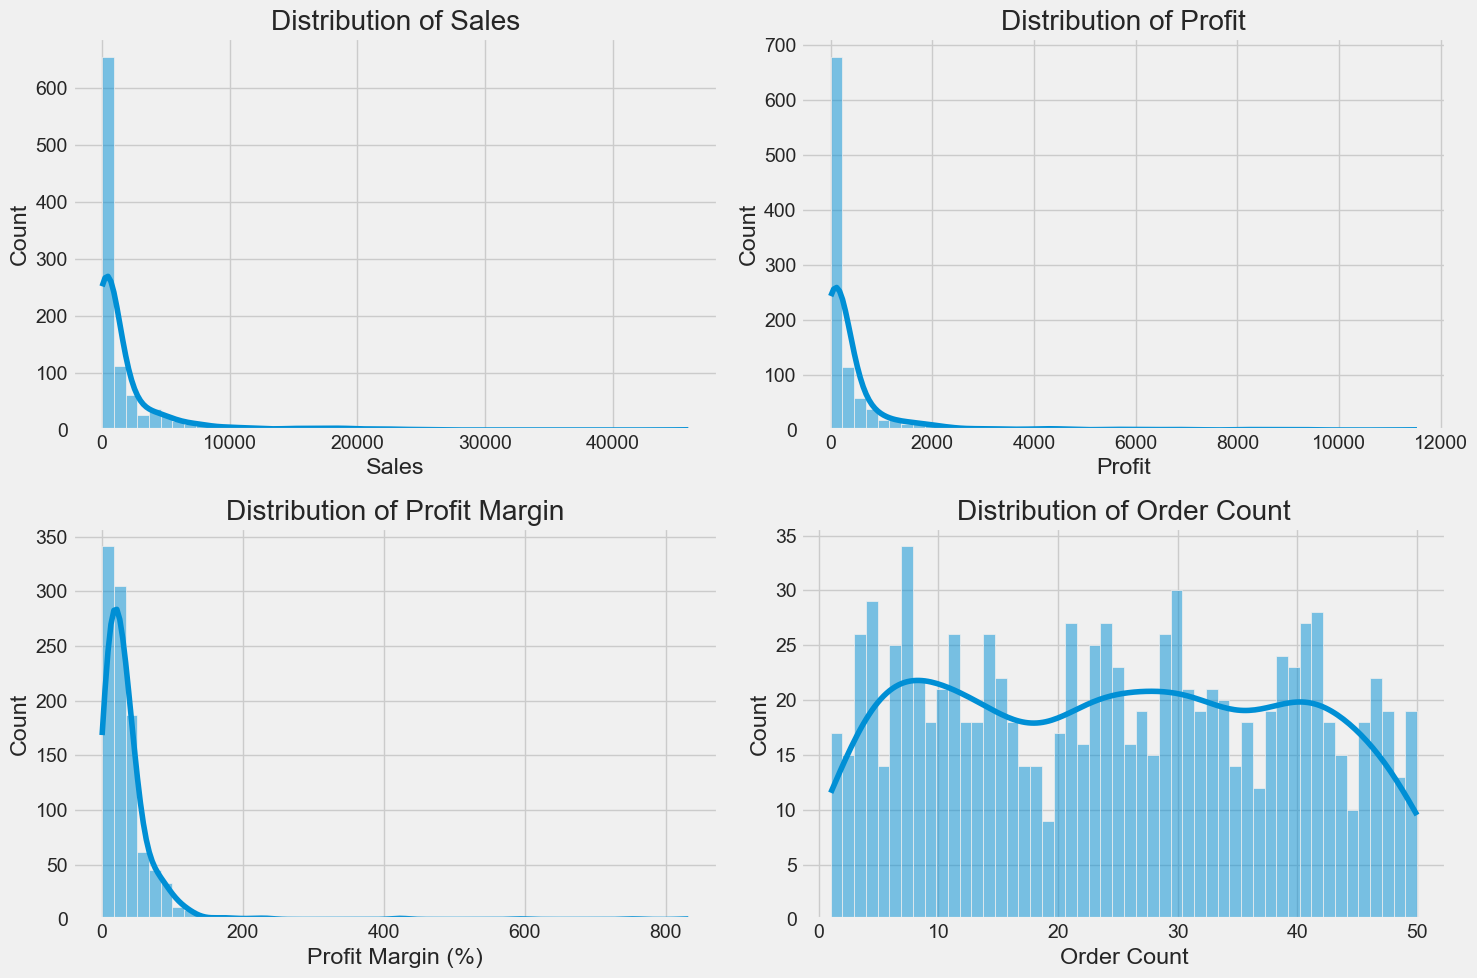

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(data_set['sale'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')

plt.subplot(2, 2, 2)
sns.histplot(data_set['profit'], bins=50, kde=True)
plt.title('Distribution of Profit')
plt.xlabel('Profit')

plt.subplot(2, 2, 3)
sns.histplot(data_set['profit_margin'], bins=50, kde=True)
plt.title('Distribution of Profit Margin')
plt.xlabel('Profit Margin (%)')

plt.subplot(2, 2, 4)
sns.histplot(data_set['order_count'], bins=50, kde=True)
plt.title('Distribution of Order Count')
plt.xlabel('Order Count')

plt.tight_layout()
plt.show()

#### Categorical variable analysis

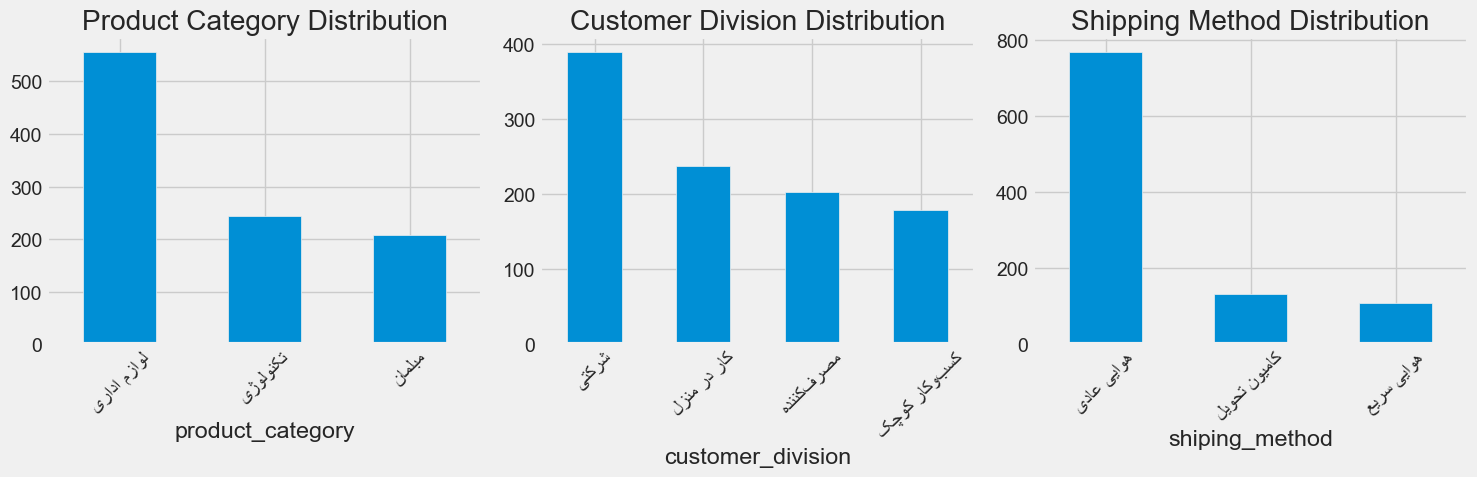

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
data_set['product_category'].value_counts().plot(kind='bar')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)


plt.subplot(1, 3, 2)
data_set['customer_division'].value_counts().plot(kind='bar')
plt.title('Customer Division Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
data_set['shiping_method'].value_counts().plot(kind='bar')
plt.title('Shipping Method Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Outlier Analysis

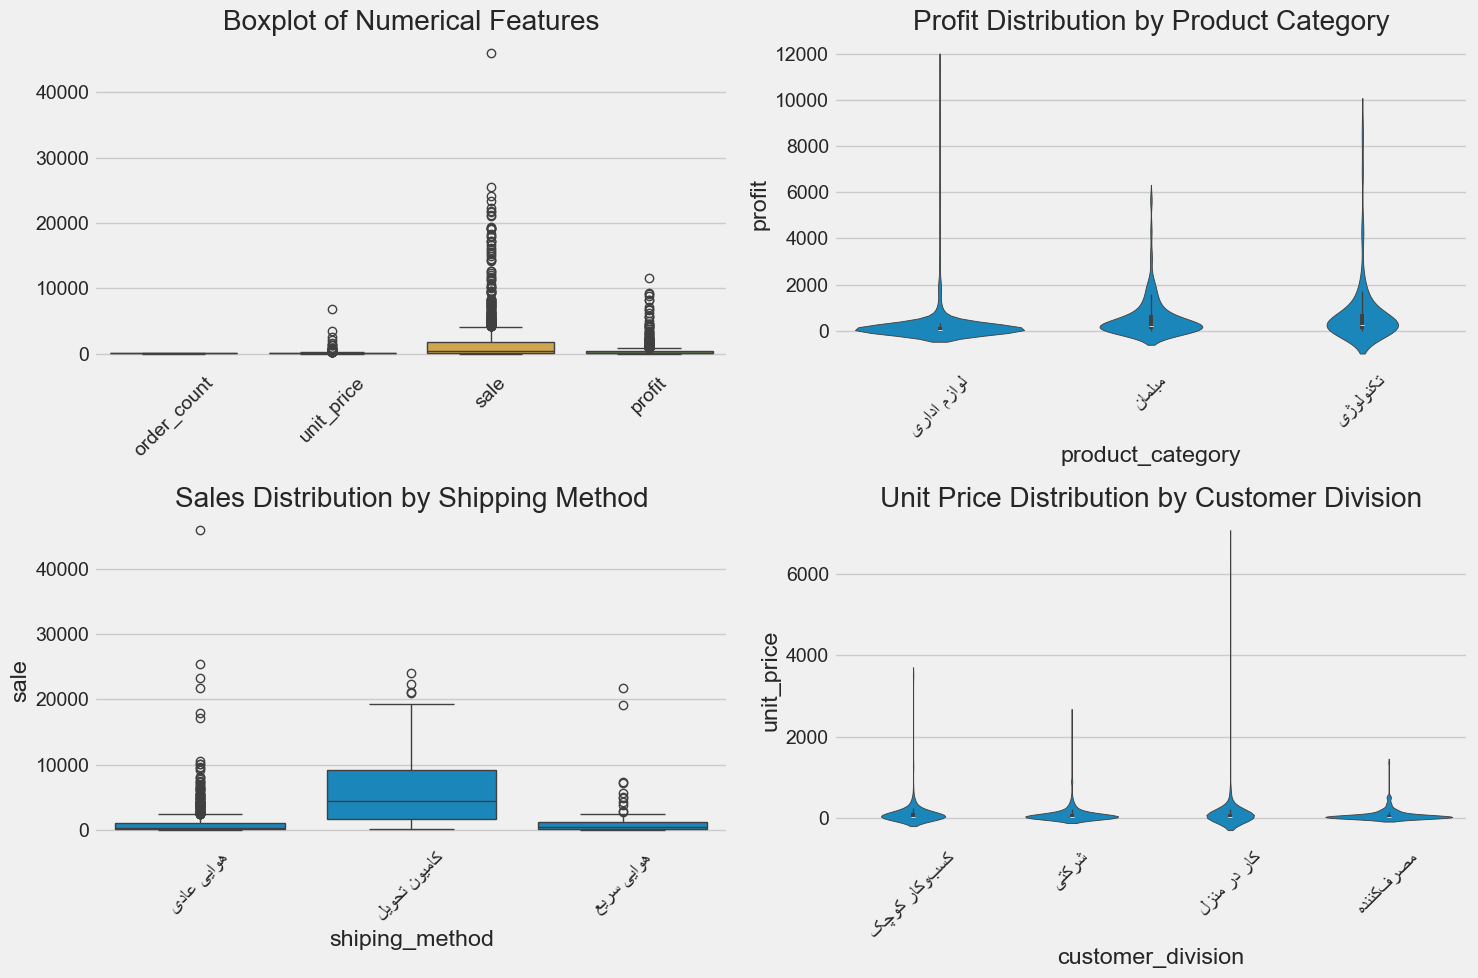


Outliers in order_count: 0 (0.00%)

Outliers in unit_price: 81 (8.04%)


,unit_price,product_category,customer_division
48,363.25,ﯼﺭﺍﺩﺍ ﻡﺯﺍﻮﻟ,ﮏﭼﻮﮐ ﺭﺎﮐﻭﺐﺴﮐ
77,500.98,ﯼﮊﻮﻟﻮﻨﮑﺗ,ﮏﭼﻮﮐ ﺭﺎﮐﻭﺐﺴﮐ
111,320.98,ﻥﺎﻤﻠﺒﻣ,ﯽﺘﮐﺮﺷ
147,296.18,ﻥﺎﻤﻠﺒﻣ,ﻩﺪﻨﻨﮐﻑﺮﺼﻣ
162,280.98,ﻥﺎﻤﻠﺒﻣ,ﯽﺘﮐﺮﺷ



Outliers in sale: 131 (13.01%)


,sale,product_category,customer_division
22,7804.53,ﯼﮊﻮﻟﻮﻨﮑﺗ,ﻝﺰﻨﻣ ﺭﺩ ﺭﺎﮐ
23,4158.12,ﯼﮊﻮﻟﻮﻨﮑﺗ,ﻝﺰﻨﻣ ﺭﺩ ﺭﺎﮐ
52,5677.61,ﯼﮊﻮﻟﻮﻨﮑﺗ,ﮏﭼﻮﮐ ﺭﺎﮐﻭﺐﺴﮐ
56,10123.02,ﯼﺭﺍﺩﺍ ﻡﺯﺍﻮﻟ,ﻩﺪﻨﻨﮐﻑﺮﺼﻣ
58,6375.28,ﯼﺭﺍﺩﺍ ﻡﺯﺍﻮﻟ,ﻝﺰﻨﻣ ﺭﺩ ﺭﺎﮐ



Outliers in profit: 129 (12.81%)


,profit,product_category,customer_division
2,1054.820000,ﻥﺎﻤﻠﺒﻣ,ﯽﺘﮐﺮﺷ
3,1748.560000,ﻥﺎﻤﻠﺒﻣ,ﯽﺘﮐﺮﺷ
9,1470.300000,ﯼﮊﻮﻟﻮﻨﮑﺗ,ﯽﺘﮐﺮﺷ
17,885.145243,ﯼﮊﻮﻟﻮﻨﮑﺗ,ﯽﺘﮐﺮﺷ
22,2057.170000,ﯼﮊﻮﻟﻮﻨﮑﺗ,ﻝﺰﻨﻣ ﺭﺩ ﺭﺎﮐ


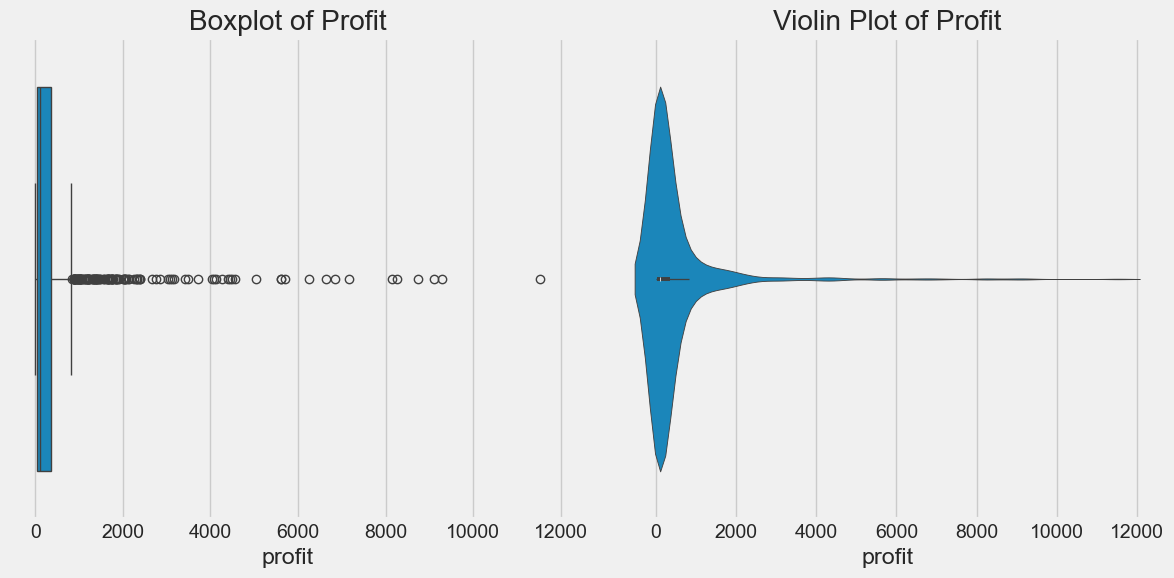

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=data_set[['order_count', 'unit_price', 'sale', 'profit']])
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.violinplot(x='product_category', y='profit', data=data_set)
plt.title('Profit Distribution by Product Category')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.boxplot(x='shiping_method', y='sale', data=data_set)
plt.title('Sales Distribution by Shipping Method')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.violinplot(x='customer_division', y='unit_price', data=data_set)
plt.title('Unit Price Distribution by Customer Division')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


def detect_outliers(dataset, column):
    q1 = dataset[column].quantile(0.25)
    q3 = dataset[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    _outliers = dataset[(dataset[column] < lower_bound) | (dataset[column] > upper_bound)]
    return _outliers

for col in ['order_count', 'unit_price', 'sale', 'profit']:
    outliers = detect_outliers(data_set, col)
    print(f"\nOutliers in {col}: {len(outliers)} ({len(outliers)/len(data_set)*100:.2f}%)")
    if len(outliers) > 0:
        display(outliers[[col, 'product_category', 'customer_division']].head())


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='profit', data=data_set)
plt.title('Boxplot of Profit')

plt.subplot(1, 2, 2)
sns.violinplot(x='profit', data=data_set)
plt.title('Violin Plot of Profit')

plt.tight_layout()
plt.show()

#### Correlation matrix

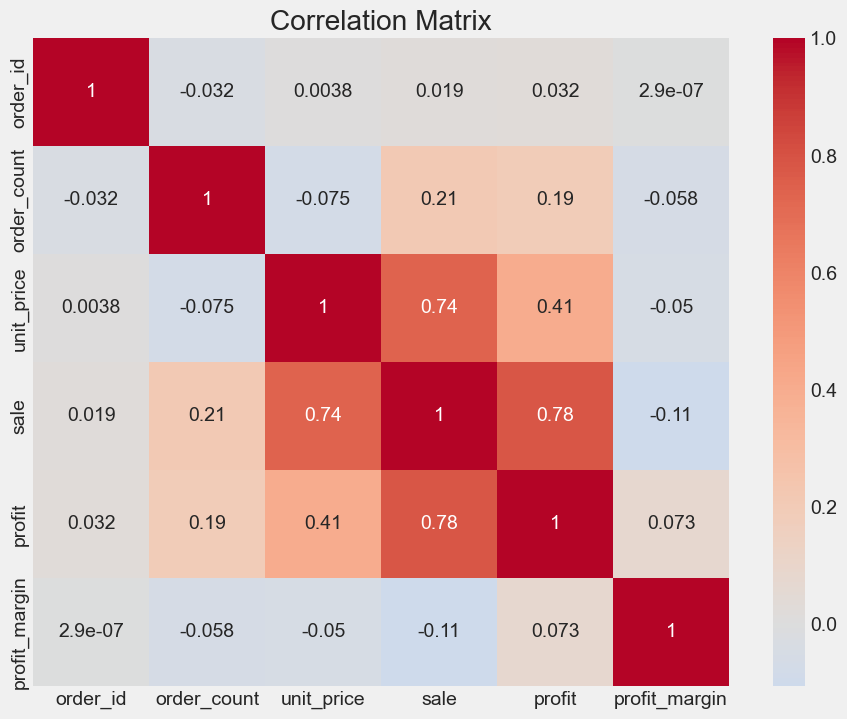

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_set.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### Statistical Tests

#### Normality test (Shapiro-Wilk)

In [15]:
sw_stat, p_value = stats.shapiro(data_set['sale'].dropna())
print(f"Sales Shapiro-Wilk test ---> Statistic = {sw_stat:.4f}, p-value = {p_value:.4f}")

sw_stat, p_value = stats.shapiro(data_set['profit'].dropna())
print(f"Profit Shapiro-Wilk test ---> Statistic = {sw_stat:.4f}, p-value = {p_value:.4f}")

Sales Shapiro-Wilk test ---> Statistic = 0.5017, p-value = 0.0000
Profit Shapiro-Wilk test ---> Statistic = 0.4157, p-value = 0.0000


#### Normality test(Kolmogorov-Smirnov)
since the dataset has a large amount of samples it is better to use k-s test

In [16]:
ks_stat, p_value = stats.kstest(data_set['sale'], 'norm', args=(np.mean(data_set['sale']), np.std(data_set['sale'])))
print(f"Sale k-s test ---> Statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")

ks_stat, p_value = stats.kstest(data_set['profit'], 'norm', args=(np.mean(data_set['profit']), np.std(data_set['profit'])))
print(f"Profit k-s test ---> Statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")

Sale k-s test ---> Statistic = 0.3133, p-value = 0.0000
Profit k-s test ---> Statistic = 0.3386, p-value = 0.0000


#### ANOVA for profit across customer division

In [17]:
divisions = data_set['customer_division'].unique()
profit_by_division = [data_set[data_set['customer_division'] == div]['profit'].dropna() for div in divisions]
anova_stat, p_value = stats.f_oneway(*profit_by_division)
print(f"ANOVA for Profit across Customer divisions ---> statistic = {anova_stat:.4f}, p-value = {p_value:.4f}")

ANOVA for Profit across Customer divisions ---> statistic = 0.8519, p-value = 0.4657


#### ANOVA for sales across product categories


In [18]:
categories = data_set['product_category'].unique()
sales_by_category = [data_set[data_set['product_category'] == cat]['sale'].dropna() for cat in categories]
anova_stat, p_value = stats.f_oneway(*sales_by_category)
print(f"ANOVA for Sales across Product Categories ---> statistic: {anova_stat:.4f}, p-value: {p_value:.4f}")

ANOVA for Sales across Product Categories ---> statistic: 46.1456, p-value: 0.0000


### Advanced Analysis

#### Time series analysis

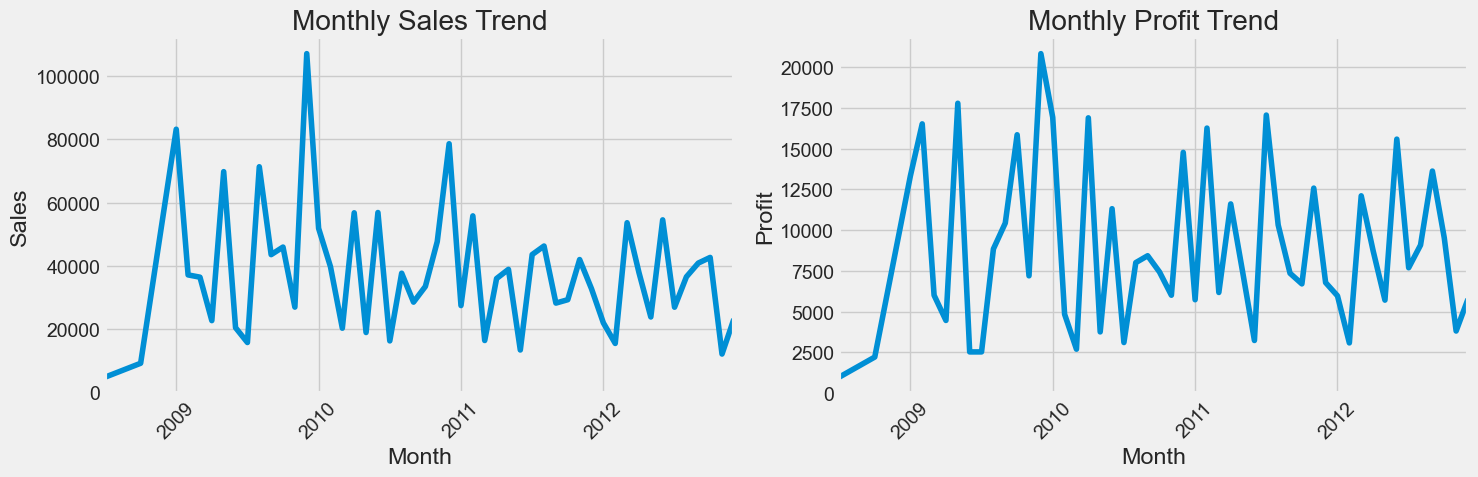

In [19]:
monthly_sales = data_set.groupby(data_set['order_date'].dt.to_period('M'))['sale'].sum()
monthly_profit = data_set.groupby(data_set['order_date'].dt.to_period('M'))['profit'].sum()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Sales')

plt.subplot(1, 2, 2)
monthly_profit.plot()
plt.title('Monthly Profit Trend')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Profit')

plt.tight_layout()
plt.show()

#### Top 10 customers by sales

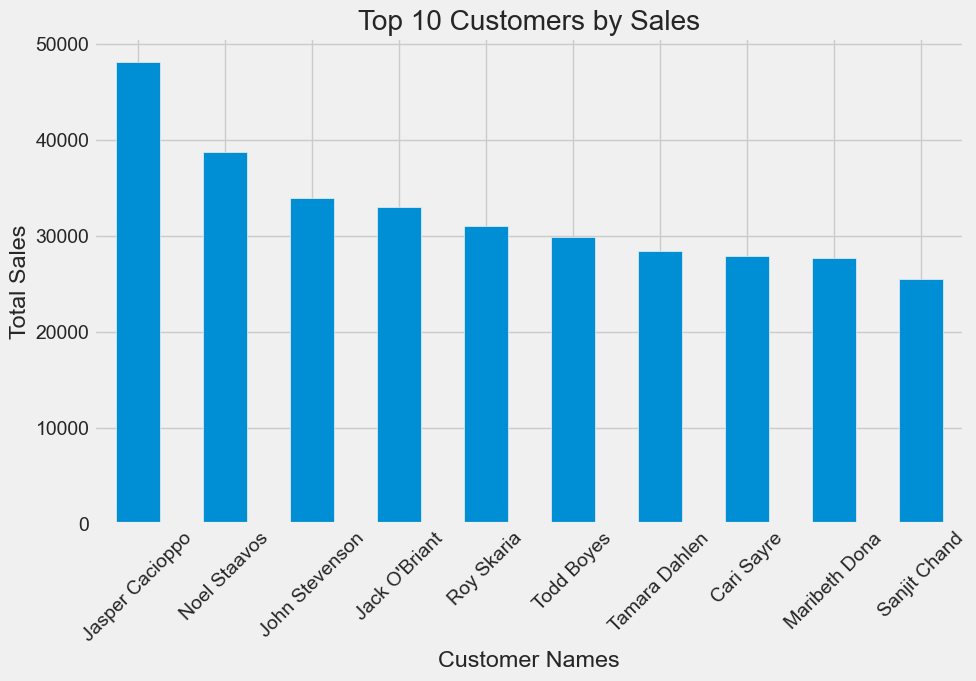

In [20]:
top_customers = data_set.groupby('customer_name')['sale'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar')
plt.title('Top 10 Customers by Sales')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.xlabel('Customer Names')
plt.show()

#### Profitability by category and division

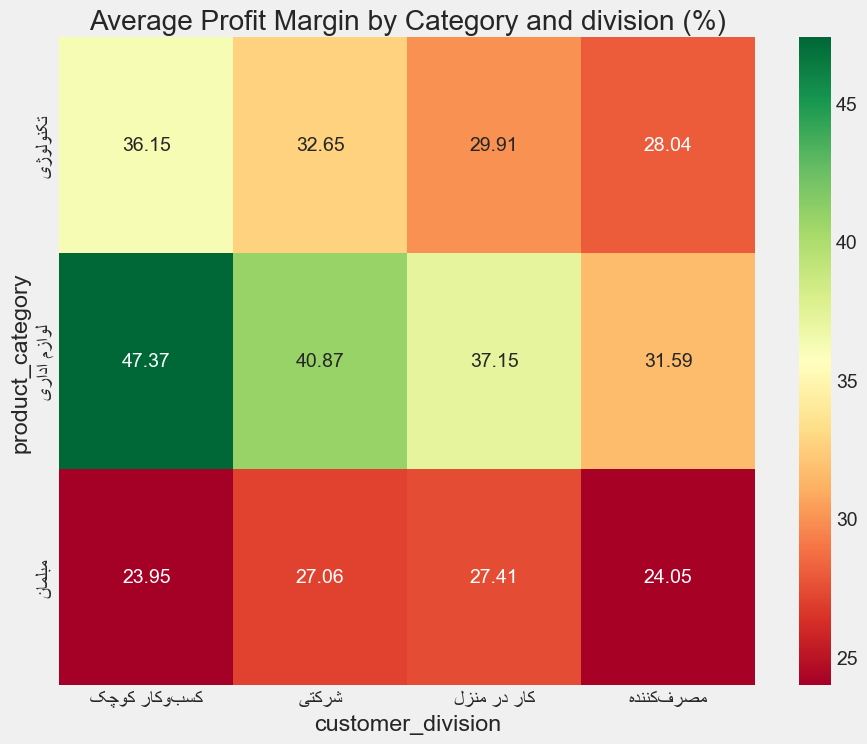

In [21]:
pivot_profit = data_set.pivot_table(values='profit_margin', 
                              index='product_category', 
                              columns='customer_division', 
                              aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_profit, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Average Profit Margin by Category and division (%)')
plt.show()

### Feature Engineering

#### create total price

In [22]:
data_set['total_price'] = data_set['order_count'] * data_set['unit_price']

#### create month and year columns

In [23]:
data_set['year'] = data_set['order_date'].dt.year
data_set['month'] = data_set['order_date'].dt.month

#### one-hot encode categorical variables

In [24]:
data_set_encoded = pd.get_dummies(data_set, columns=['shiping_method', 'customer_division', 'product_category'], drop_first=True)

### Machine Learning Models

#### preparing data for random forrest

##### features and target

In [25]:
X = data_set_encoded.drop(columns=['order_id', 'order_date', 'customer_name', 'sale', 'profit'])
y = data_set_encoded['profit']

##### split data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Scale numerical features

In [27]:
numeric_columns = ['order_count', 'unit_price', 'year', 'month', 'total_price']
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[numeric_columns])
X_test_num = scaler.transform(X_test[numeric_columns])

##### Combine scaled numerical features with one-hot encoded features

In [28]:
X_train_scaled = np.hstack([X_train_num, X_train.drop(columns=numeric_columns)])
X_test_scaled = np.hstack([X_test_num, X_test.drop(columns=numeric_columns)])

#### Random Forrest

##### Train Random Forest model

In [29]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


##### Predictions

In [30]:
y_pred = rf.predict(X_test_scaled)

###### Evaluate

In [31]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Performance with One-Hot Encoding:")
print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

Random Forest Performance with One-Hot Encoding:
MSE: 18273.30
R2 Score: 0.98


##### Feature importance

In [32]:
feature_names = numeric_columns + [col for col in X_train.columns if col not in numeric_columns]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance with One-Hot Encoding:")
feature_importance


Feature Importance with One-Hot Encoding:


,Feature,Importance
4,total_price,0.681485
5,profit_margin,0.263279
1,unit_price,0.026460
0,order_count,0.009865
3,month,0.005740
9,customer_division_ﻝﺰﻨﻣ ﺭﺩ ﺭﺎﮐ,0.005164
2,year,0.003484
7,shiping_method_ﻞﯾﻮﺤﺗ ﻥﻮﯿﻣﺎﮐ,0.001193
10,customer_division_ﻩﺪﻨﻨﮐﻑﺮﺼﻣ,0.001049
11,product_category_ﯼﺭﺍﺩﺍ ﻡﺯﺍﻮﻟ,0.000902


#### Customer clustering with K-means

##### Prepare data for clustering

In [33]:
cluster_features = data_set.groupby('customer_name').agg({
    'sale': 'sum',
    'profit': 'mean',
    'order_count': 'count'
}).reset_index()

##### Scale features

In [34]:
cluster_data = cluster_features[['sale', 'profit', 'order_count']]
cluster_data_scaled = scaler.fit_transform(cluster_data)

##### Finding optimal clusters(elbow method)

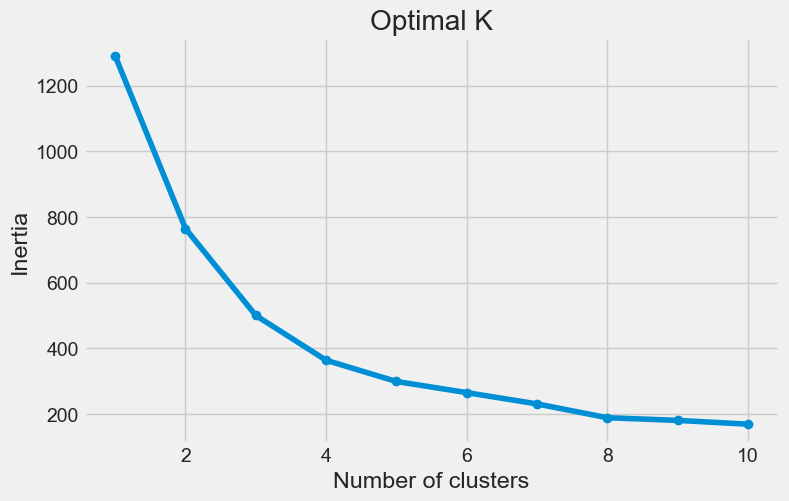

In [35]:
inertia = [KMeans(n_clusters=k, random_state=42).fit(cluster_data_scaled).inertia_ for k in range(1, 11)]

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

##### K-Means with K = 3

In [36]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(cluster_data_scaled)
cluster_features['cluster'] = clusters

##### Visualize clusters with PCA

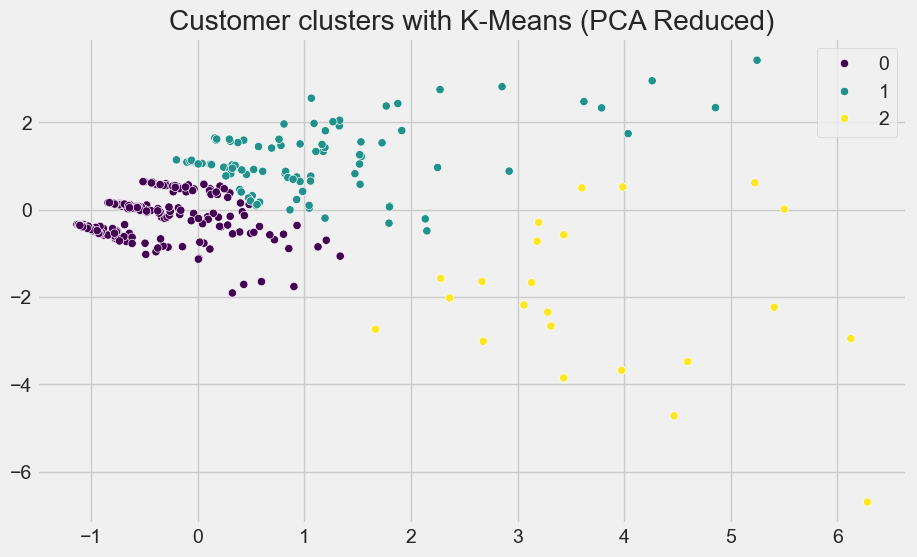

In [37]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_data_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette='viridis')
plt.title('Customer clusters with K-Means (PCA Reduced)')
plt.show()

##### Analyze clusters

In [38]:
print("\nCluster Characteristics:")
cluster_features.groupby('cluster').mean(numeric_only =True)


Cluster Characteristics:


,sale,profit,order_count
cluster,,,
0,1860.878952,224.918703,1.653968
1,8545.872029,413.484887,4.652174
2,22122.208359,3158.212959,2.521739
